# Sluggish Random Walk and Sub-diffusive Processes

#### Recall in discrete time sluggish random walk,  the step probability decreases with the distance from the origin.

It was clearly defined that the probability to hop left or right is:
$$p = \dfrac{1}{\left(\frac{|x|}{a}\right)^\alpha+2}$$
and the probability to stay in place is
$$ 1-2p = \dfrac{\left(\frac{|x|}{a}\right)^\alpha}{\left(\frac{|x|}{a}\right)^\alpha+2}$$.

We now add a resetting probability $r$ at each time step. The rule becomes:
$$
x_{t+1} = \begin{cases}
x_0 & \text{with probability } \; r\\
x_t + 1 & \text{with probability } \; (1-r)\cdot p\\
x_t - 1 & \text{with probability } \; (1-r)\cdot p\\
x_t & \text{with probability } \; (1-r)\cdot (1-2p)
\end{cases}
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

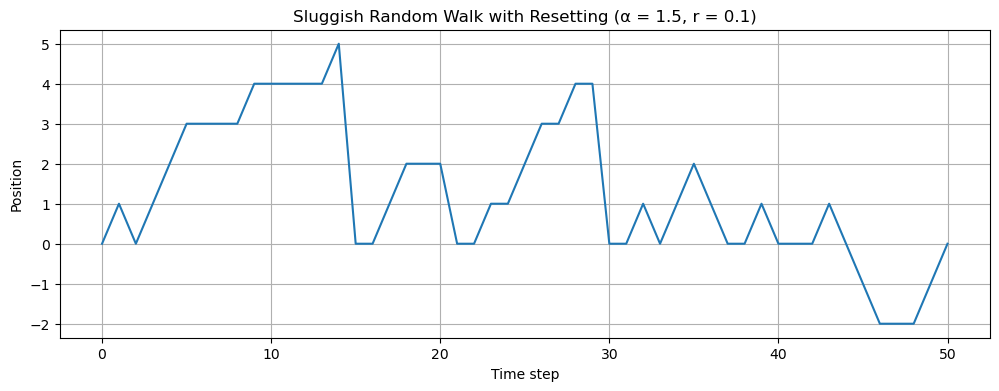

In [2]:
def sluggish_walk_discrete_with_resetting(T, x0, alpha, reset_prob):
    """Simulate sluggish random walk with stochastic resetting."""
    x = np.zeros(T + 1)
    for t in range(1, T + 1):
        pos = x[t - 1]

        if np.random.rand() < reset_prob:
            x[t] = x0  # Reset to origin
        else:
            denom = abs(pos) ** alpha + 2
            p = 1 / denom
            r = np.random.rand()

            if r < p:
                x[t] = pos + 1
            elif r < 2 * p:
                x[t] = pos - 1
            else:
                x[t] = pos  # Stay
    return x

# Parameters
T = 50         # Steps
x0 = 0          # Starting position
alpha = 1.5      # Sluggishness parameter
reset_prob = 0.1  # Resetting probability

# Run and plot
trajectory = sluggish_walk_discrete_with_resetting(T, x0, alpha, reset_prob)
plt.figure(figsize=(12, 4))
plt.plot(trajectory)
plt.title(f'Sluggish Random Walk with Resetting (α = {alpha}, r = {reset_prob})')
plt.xlabel('Time step')
plt.ylabel('Position')
plt.grid(True)
plt.show()

##### We can also compare for different levels of sluggishness

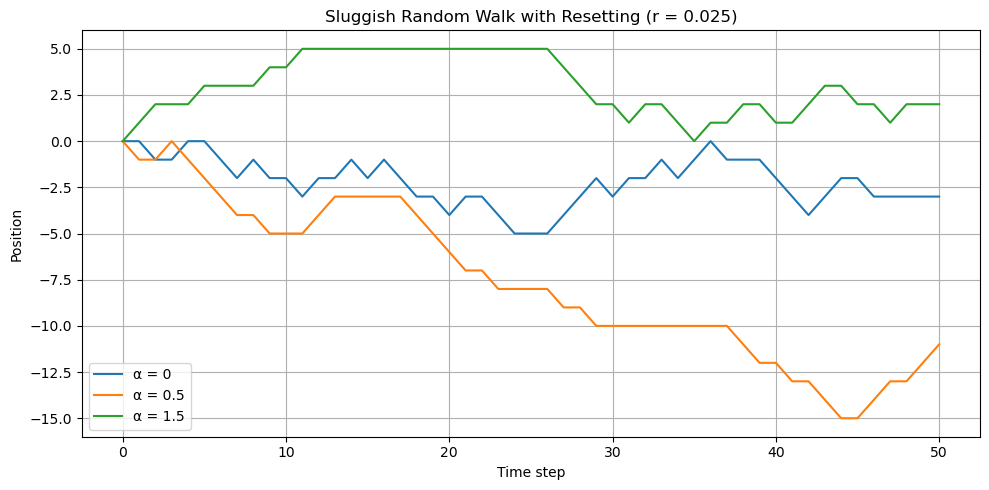

In [3]:
# Parameters
T = 50
x0 = 0
reset_prob = 0.025
alphas = [0, 0.5, 1.5]

# Plot all trajectories
plt.figure(figsize=(10, 5))

for alpha in alphas:
    trajectory = sluggish_walk_discrete_with_resetting(T, x0, alpha, reset_prob)
    plt.plot(trajectory, label=f'α = {alpha}')

plt.title(f'Sluggish Random Walk with Resetting (r = {reset_prob})')
plt.xlabel('Time step')
plt.ylabel('Position')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Continuous Case

We propose
$$
 \frac{\partial P(x,t|x_0)}{\partial t} = \frac{\partial^2}{\partial x^2}\Bigl[\frac{P(x,t|x_0)}{|x|^\alpha}\Bigr] - r P(x,t|x_0) + r \delta(x - x_0).
$$
Check PDF for Derivation.

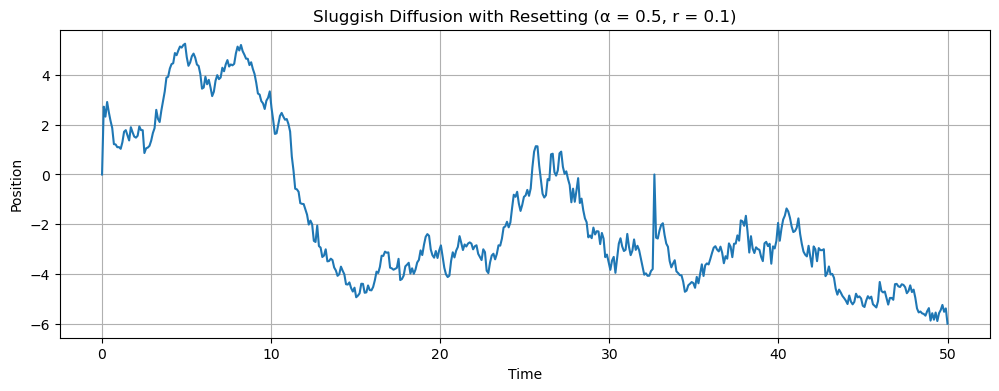

In [4]:
def sluggish_walk_continuous_with_resetting(alpha, T, dt, reset_rate, x0, epsilon=5e-2):
    """
    Simulate a sluggish diffusion process with stochastic resetting.
    """
    steps = int(T / dt)
    x = np.zeros(steps)
    x[0] = x0

    for t in range(1, steps):
        # Decide whether to reset
        if np.random.rand() < reset_rate * dt:
            x[t] = x0  # Reset to origin
        else:
            D = 1 / (abs(x[t-1])**alpha + epsilon)
            noise = np.random.randn()
            x[t] = x[t-1] + np.sqrt(2 * D * dt) * noise

    time = np.linspace(0, T, steps)
    return time, x

# Parameters
alpha = 0.5        # Sluggishness exponent
T = 50         # Total time
dt = 0.1         # Time step
reset_rate = 0.1   # Resetting rate per unit time
x0 = 0

# Simulate and plot
time, traj = sluggish_walk_continuous_with_resetting(alpha, T, dt, reset_rate, x0)

plt.figure(figsize=(12, 4))
plt.plot(time, traj)
plt.title(f'Sluggish Diffusion with Resetting (α = {alpha}, r = {reset_rate})')
plt.xlabel('Time')
plt.ylabel('Position')
plt.grid(True)
plt.show()

##### We can also compare for different levels of sluggishness

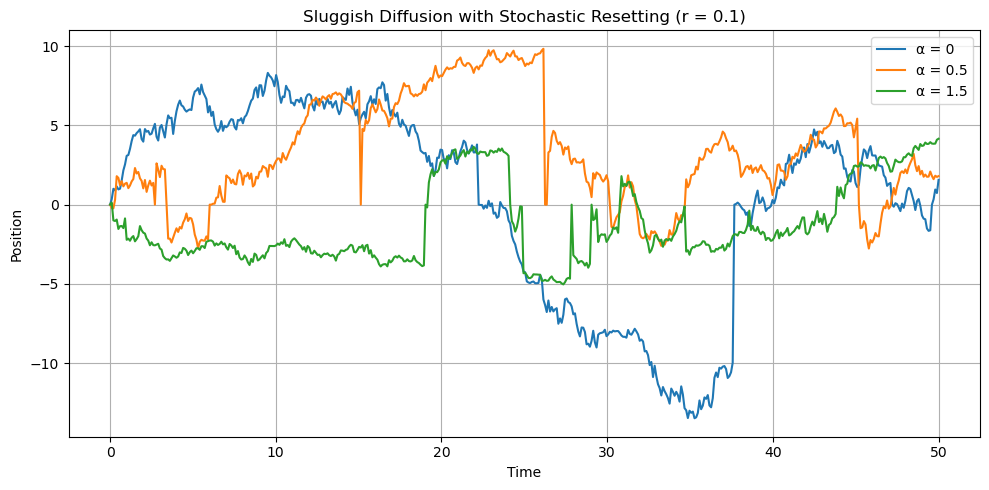

In [5]:
# Parameters
T = 50
dt = 0.1
reset_rate = 0.1
x0 = 0
alphas = [0, 0.5, 1.5]

# Plot all trajectories
plt.figure(figsize=(10, 5))

for alpha in alphas:
    time, traj = sluggish_walk_continuous_with_resetting(alpha, T, dt, reset_rate, x0)
    plt.plot(time, traj, label=f'α = {alpha}')

plt.title(f'Sluggish Diffusion with Stochastic Resetting (r = {reset_rate})')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Probability distribution of final positions

### Analytics vs Simulation

We derived
$$
p_{\text{st}}(x) = \frac{r^{\frac{2\alpha+3}{2(\alpha+2)}}}{\Gamma\left(\frac{\alpha+1}{\alpha+2}\right)(\alpha+2)^{\frac{\alpha+1}{\alpha+2}}}|x|^{\alpha + 1/2} K_{\frac{1}{\alpha+2}}\left(\frac{2\sqrt{r}}{\alpha+2}|x|^{(\alpha+2)/2}\right)
$$
Check PDF for Derivation.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma, kv
from scipy.integrate import quad
from collections import Counter

In [7]:
def probability_distribution_continuous_with_resetting1(alpha, T, dt, reset_rate, x0, N, epsilon=5e-2):
    """
    Simulate N continuous-time sluggish walks with resetting and return the distribution of final positions.
    """
    final_positions = []
    for _ in range(N):
        _, x = sluggish_walk_continuous_with_resetting(alpha, T, dt, reset_rate, x0, epsilon)
        final_positions.append(x[-1])
    return final_positions

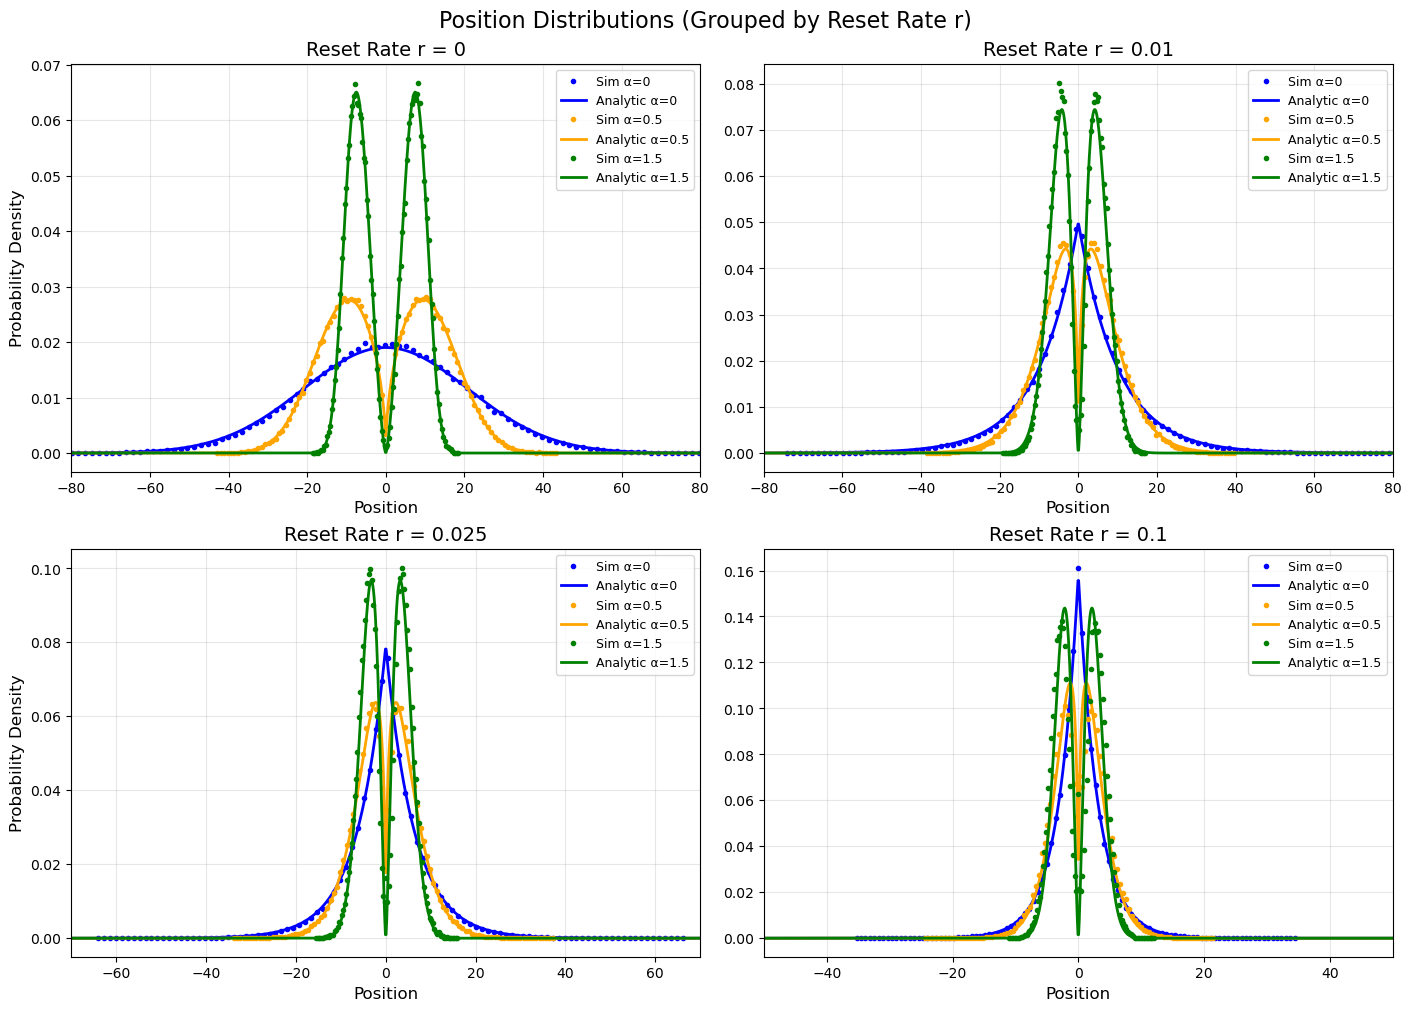

In [9]:
def plot_distributions_grouped_by_reset_rate(T, dt, N, x0, alpha_values, reset_rates, bins=100):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
    axs = axs.flatten()
    
    colors = ['blue', 'orange', 'green']  # One for each α

    # Define x-axis limits per reset rate
    xlims_dict = {
        0: (-85, 85),
        0.01: (-80, 80),
        0.025: (-70, 70),
        0.1: (-40, 40),
    }

    for i, r in enumerate(reset_rates):
        ax = axs[i]
        x_min, x_max = xlims_dict[r]
        x_grid = np.linspace(x_min, x_max, 1000)

        for j, alpha in enumerate(alpha_values):
            # --- Simulation histogram ---
            positions = probability_distribution_continuous_with_resetting1(alpha, T, dt, r, x0, N)
            hist, bin_edges = np.histogram(positions, bins=bins, density=True)
            bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            ax.plot(bin_centers, hist, marker='o', linestyle='None', markersize=4, color=colors[j], label=f'Sim α={alpha}')

            # --- Analytical solution ---
            if r == 0:
                mu = 1 / (alpha + 2)
                prefactor = (mu**(1 - 2*mu)) / (2 * gamma(1 - mu)) / (T**(1 - mu))
                abs_x = np.abs(x_grid)
                p = np.zeros_like(x_grid)
                mask = abs_x > 0
                abs_x_masked = abs_x[mask]
                term1 = abs_x_masked ** alpha
                term2 = np.exp(-mu**2 * abs_x_masked ** (1 / mu) / T)
                p[mask] = prefactor * term1 * term2
            else:
                nu = 1 / (alpha + 2)
                beta_val = (alpha + 2) / 2
                gamma_val = 2 * np.sqrt(r) / (alpha + 2)

                def integrand(u):
                    return u ** (alpha + 0.5) * kv(nu, gamma_val * u ** beta_val)

                integral, _ = quad(integrand, 0, np.inf, limit=2000)
                norm = 1 / (2 * integral)

                abs_x = np.abs(x_grid)
                p = np.zeros_like(x_grid)
                mask = abs_x > 0
                abs_x_masked = abs_x[mask]
                p[mask] = norm * (abs_x_masked ** (alpha + 0.5)) * kv(nu, gamma_val * abs_x_masked ** beta_val)

            ax.plot(x_grid, p, color=colors[j], linestyle='-', lw=2, label=f'Analytic α={alpha}')

        # Decorate subplot
        ax.set_title(f'Reset Rate r = {r}', fontsize=14)
        ax.set_xlabel('Position', fontsize=12)
        if i in [0, 2]:
            ax.set_ylabel('Probability Density', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)
        ax.set_xlim(x_min-5, x_max+5)

    plt.suptitle('Position Distributions (Grouped by Reset Rate r)', fontsize=16)
    plt.show()

plot_distributions_grouped_by_reset_rate(
    T=250,
    dt=0.1,
    N=100000,
    x0=0,
    alpha_values=[0, 0.5, 1.5],
    reset_rates=[0, 0.01, 0.025, 0.1],
    bins=100
)


#### For each alpha, we look at final position distribution for different resetting values $r\in \{0, 0.01, 0.025, 0.1\}$

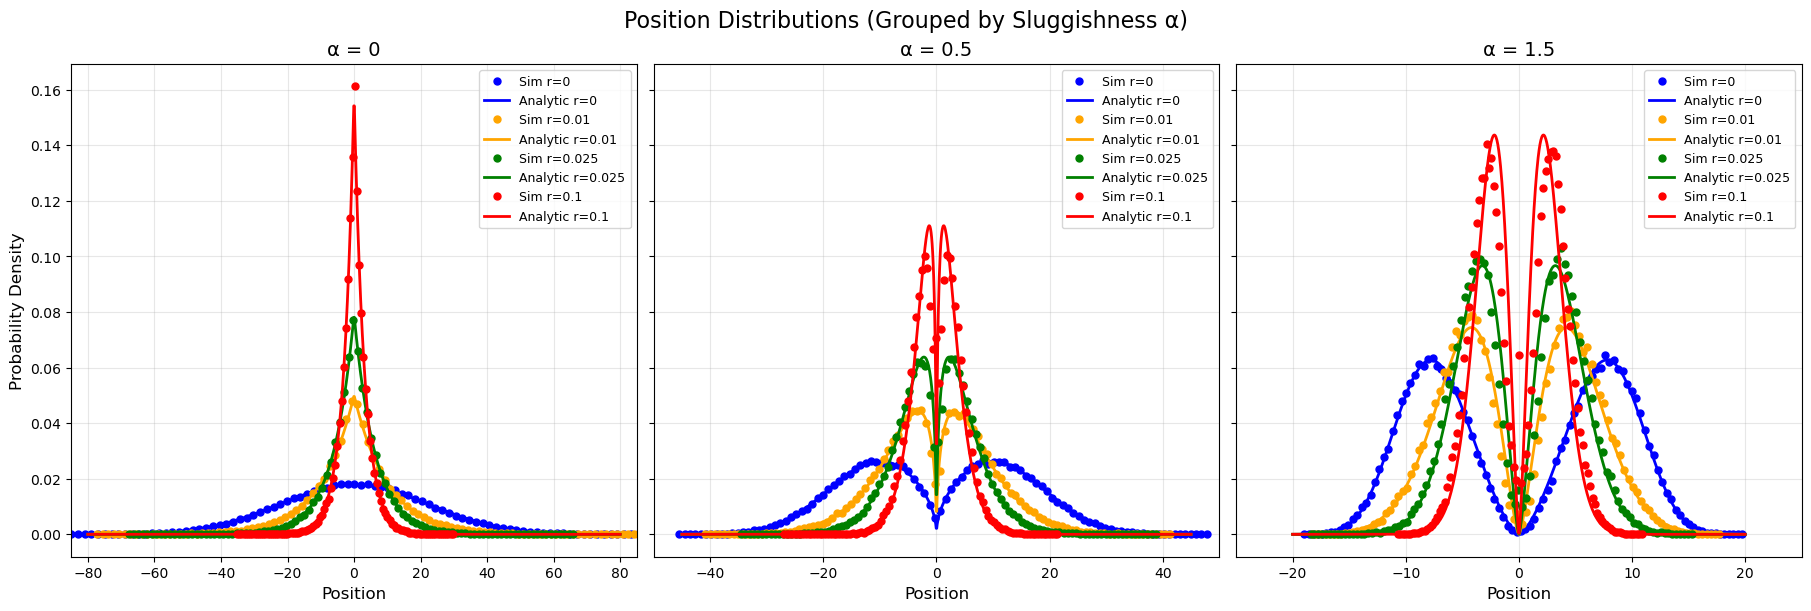

In [17]:
def plot_combined_continuous_distributions(T, dt, N, x0, alpha_values, reset_rates, bins=100):
    fig, axs = plt.subplots(1, len(alpha_values), figsize=(18, 6), sharey=True, constrained_layout=True)
    axs = axs.flatten()
    
    colors = ['blue', 'orange', 'green', 'red']  # One for each r

    # Define x-axis limits per alpha
    xlims_dict = {
        0: (-80, 80),
        0.5: (-45, 45),
        1.5: (-20, 20)
    }

    for i, alpha in enumerate(alpha_values):
        ax = axs[i]
        x_min, x_max = xlims_dict[alpha]
        x_grid = np.linspace(x_min, x_max, 1000)

        for j, r in enumerate(reset_rates):
            # --- Simulation histogram ---
            positions = probability_distribution_continuous_with_resetting1(alpha, T, dt, r, x0, N)
            hist, bin_edges = np.histogram(positions, bins=bins, density=True)
            bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            ax.plot(bin_centers, hist, marker='o', linestyle='None', markersize=5, color=colors[j], label=f'Sim r={r}')

            # --- Analytical solution ---
            if r == 0:
                mu = 1 / (alpha + 2)
                prefactor = (mu**(1 - 2*mu)) / (2 * gamma(1 - mu)) / (T**(1 - mu))
                abs_x = np.abs(x_grid)
                p = np.zeros_like(x_grid)
                mask = abs_x > 0
                abs_x_masked = abs_x[mask]
                term1 = abs_x_masked ** alpha
                term2 = np.exp(-mu**2 * abs_x_masked ** (1 / mu) / T)
                p[mask] = prefactor * term1 * term2
            else:
                nu = 1 / (alpha + 2)
                beta_val = (alpha + 2) / 2
                gamma_val = 2 * np.sqrt(r) / (alpha + 2)

                def integrand(u):
                    return u ** (alpha + 0.5) * kv(nu, gamma_val * u ** beta_val)

                integral, _ = quad(integrand, 0, np.inf, limit=2000)
                norm = 1 / (2 * integral)

                abs_x = np.abs(x_grid)
                p = np.zeros_like(x_grid)
                mask = abs_x > 0
                abs_x_masked = abs_x[mask]
                p[mask] = norm * (abs_x_masked ** (alpha + 0.5)) * kv(nu, gamma_val * abs_x_masked ** beta_val)

            ax.plot(x_grid, p, color=colors[j], linestyle='-', lw=2, label=f'Analytic r={r}')

        # Decorate subplot
        ax.set_title(f'α = {alpha}', fontsize=14)
        ax.set_xlabel('Position', fontsize=12)
        ax.set_xlim(x_min-5, x_max+5)
        if i == 0:
            ax.set_ylabel('Probability Density', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)

    plt.suptitle('Position Distributions (Grouped by Sluggishness α)', fontsize=16)
    plt.show()

# Run the plot
plot_combined_continuous_distributions(
    T=250,
    dt=0.1,
    N=100000,
    x0=0,
    alpha_values=[0, 0.5, 1.5],
    reset_rates=[0, 0.01, 0.025, 0.1],
    bins=100
)